# Analysis - Sex Offender Potential Noncompliance

Looking into the results of [geodata fusion](Geodata%20Fusion.ipynb) and the sex offender locations in order to identify sex offenders who reside within a restricted area. 

Here we will load in datasets we've worked on in prior notebooks, reduce the data down to only the elements and portions within St. Louis City, identify sex offenders located within restricted zones vs. outside restricted zones, and display/output the results. 

In this notebook, we look to answer **Q3:** Are there any persons currently on the sex offender registry who may be in violation of the special consideration restrictions?

In [1]:
# IMPORTS
import geopandas as gpd
import pandas as pd

import os
import urllib.request
import requests
import shutil
from pathlib import Path
from zipfile import ZipFile

import matplotlib.pyplot as plt
from matplotlib import pyplot

import folium
import folium.plugins as plugins

from shapely.geometry import Point, Polygon

from geopandas.tools import overlay

In [2]:
# a few more imports specfic to the database process
import getpass

import psycopg2
import numpy
from psycopg2.extensions import adapt, register_adapter, AsIs

from sqlalchemy import create_engine


### Gather data

#### Establish database connection

In [3]:
# get user password for connecting to the db
mypasswd = getpass.getpass()

········


In [4]:
# set up db connection
conn = psycopg2.connect(database = 'cappsds_psmd39', 
                              user = 'psmd39', 
                              host = 'pgsql.dsa.lan',
                              password = mypasswd)


#### Pull sex offender location data from PostGIS database

In [5]:
# create sql statement and pull from db into a geopandas dataframe
sql = "SELECT * FROM stlsexoffenders;"
gdf_so = gpd.read_postgis(sql, conn, geom_col='geometry')
gdf_so.head()


randomid                 name             address         city  st    zip  \
0       118  ABERNATHY, STEVIE A      133 BAYVIEW DR  SAINT LOUIS  MO  63135   
1      1904    ABRAMS, NORVELL L      1946 HEBERT ST  SAINT LOUIS  MO  63107   
2     33715      ADAMS, BRYANT A  7614 FLORISSANT RD  SAINT LOUIS  MO  63121   
3     18814      ADAMS, DAMEON A       8022 JOEL AVE  SAINT LOUIS  MO  63123   
4     43875      ADAMS, GEORGE N  9921 HEATHERTON DR  SAINT LOUIS  MO  63123   

          county                          offense     offense_city  \
0       ST LOUIS         STATUTORY RAPE-2ND DEGRE        ST PETERS   
1  ST LOUIS CITY             ATTEMPT SEXUAL ABUSE         PAGEDALE   
2       ST LOUIS  STAT RAPE-1ST DEG-PERS UNDER 14         ST LOUIS   
3       ST LOUIS            CHILD MOLESTATION-1ST    ST LOUIS CITY   
4       ST LOUIS          CHILD MOLEST-1ST DEGREE  ST LOUIS COUNTY   

  offense_state  ... tier  date_of_birth offense_date conviction_date  \
0            MO  ...    3     1991-11-11   2014-01-26      2015-12-18   
1            MO  ...    2     1973-05-08   2002-10-14      2003-02-21   
2            MO  ...    3     1988-04-16   2005-09-18      2006-10-06   
3            MO  ...    3     1977-12-05   1996-09-01      1997-07-29   
4            MO  ...    3     1951-07-14   2007-01-01      2017-06-15   

   confinement_release_date probation/parole_release_date  \
0                2019-08-23           2023-08-09 00:00:00   
1                2006-10-14           2006-10-14 00:00:00   
2                      None                          None   
3                1998-01-22                          None   
4                      None                          None   

  offender_age_at_time_of_offense        lat       long  \
0                              22  38.744944 -90.290619   
1                              29  38.654602 -90.201029   
2                              17  38.710232 -90.301116   
3                              18  38.564085 -90.313727   
4                              55  38.539049 -90.354750   

                     geometry  
0  POINT (-90.29062 38.74494)  
1  POINT (-90.20103 38.65460)  
2  POINT (-90.30112 38.71023)  
3  POINT (-90.31373 38.56409)  
4  POINT (-90.35475 38.53905)  

[5 rows x 24 columns]

In [6]:
gdf_so.shape

(5727, 24)

#### Pull restricted area geometry from PostGIS database

In [7]:
# create sql statement and pull from db into a geopandas dataframe
sql = "SELECT * FROM stlrestrictedflat;"
gdf_restricted = gpd.read_postgis(sql, conn, geom_col='geometry')
gdf_restricted.head()


geometry
0  MULTIPOLYGON (((268891.224 298458.770, 268887....

In [8]:
# convert to same CRS as the SO location data
# make sure our datasets are using the same CRS!
print('Starting restricted area (gdf_restricted) CRS:', gdf_restricted.crs)
print('Starting sex offender locations (gdf_so) CRS:', gdf_so.crs)
print('------------')

# convert to a common CRS
gdf_restricted = gdf_restricted.to_crs(gdf_so.crs)
print('New restricted area (gdf_restricted) CRS:', gdf_restricted.crs)


Starting restricted area (gdf_restricted) CRS: epsg:6512
Starting sex offender locations (gdf_so) CRS: epsg:4326
------------
New restricted area (gdf_restricted) CRS: epsg:4326


#### Pull individual restricted areas, too (public, private, childcare)

In [9]:
# create sql statement and pull childcare restricted areas from db into a geopandas dataframe
sql = "SELECT facility, latitude, longitude, geometry FROM stlchildcare;"
gdf_restricted_child = gpd.read_postgis(sql, conn, geom_col='geometry')

# convert to same CRS as above
gdf_restricted_child = gdf_restricted_child.to_crs(gdf_so.crs)
print('New restricted area (gdf_restricted_child) CRS:', gdf_restricted_child.crs)

gdf_restricted_child.head()

New restricted area (gdf_restricted_child) CRS: epsg:4326


facility   latitude  longitude  \
0                          "TRAINING UP A CHILD" LLC  38.756866 -90.281532   
1  A BRIGHTER FUTURE CHILDCARE AND DEVELOPMENT CE...  38.749010 -90.255613   
2               A CHILD'S HEART LEARNING CENTER LLC.  38.699140 -90.328902   
3                 A GENERATION CHOSEN PRE SCHOOL INC  38.727633 -90.302545   
4                         A PLACE FOR CHILDREN, INC.  38.566986 -90.410277   

                                            geometry  
0  POLYGON ((-90.27803 38.75686, -90.27804 38.756...  
1  POLYGON ((-90.25211 38.74900, -90.25212 38.748...  
2  POLYGON ((-90.32540 38.69914, -90.32542 38.698...  
3  POLYGON ((-90.29904 38.72763, -90.29906 38.727...  
4  POLYGON ((-90.40678 38.56698, -90.40680 38.566...

In [10]:
# create sql statement and pull public school restricted areas from db into a geopandas dataframe
sql = "SELECT facility, latitude, longitude, geometry  FROM stlpubschools;"
gdf_restricted_pub = gpd.read_postgis(sql, conn, geom_col='geometry')

# convert to same CRS as above
gdf_restricted_pub = gdf_restricted_pub.to_crs(gdf_so.crs)
print('New restricted area (gdf_restricted_pub) CRS:', gdf_restricted_pub.crs)

gdf_restricted_pub.head()

New restricted area (gdf_restricted_pub) CRS: epsg:4326


facility   latitude  longitude  \
0                Eagle Gravois Park  38.588934 -90.228330   
1  Dewey School-Internat'L. Studies  38.630979 -90.302469   
2                    Dunbar and Br.  38.645176 -90.220644   
3    Grand Center Arts Academy High  38.640595 -90.230978   
4    Gateway Science Acad/St. Louis  38.606788 -90.302452   

                                            geometry  
0  POLYGON ((-90.22487 38.58893, -90.22488 38.588...  
1  POLYGON ((-90.29890 38.63106, -90.29892 38.630...  
2  POLYGON ((-90.21708 38.64526, -90.21709 38.644...  
3  POLYGON ((-90.22730 38.64066, -90.22732 38.640...  
4  POLYGON ((-90.29889 38.60687, -90.29891 38.606...

In [11]:
# create sql statement and pull private school restricted areas from db into a geopandas dataframe
sql = "SELECT facility, latitude, longitude, geometry FROM stlpvtschools;"
gdf_restricted_pvt = gpd.read_postgis(sql, conn, geom_col='geometry')

# convert to same CRS as above
gdf_restricted_pvt = gdf_restricted_pvt.to_crs(gdf_so.crs)
print('New restricted area (gdf_restricted_pvt) CRS:', gdf_restricted_pvt.crs)

gdf_restricted_pvt.head()

New restricted area (gdf_restricted_pvt) CRS: epsg:4326


facility   latitude  longitude  \
0    ST JOHNS LUTHERAN SCHOOL  38.592390 -90.581750   
1  ST LOUIS CHRISTIAN ACADEMY  38.616410 -90.231680   
2              FORSYTH SCHOOL  38.645024 -90.302885   
3    MOST HOLY TRINITY SCHOOL  38.660504 -90.199686   
4    CARDINAL RITTER CLG PREP  38.642260 -90.234630   

                                            geometry  
0  POLYGON ((-90.57826 38.59240, -90.57827 38.592...  
1  POLYGON ((-90.22819 38.61641, -90.22820 38.616...  
2  POLYGON ((-90.29938 38.64503, -90.29940 38.644...  
3  POLYGON ((-90.19620 38.66050, -90.19621 38.660...  
4  POLYGON ((-90.23151 38.64212, -90.23153 38.641...

In [12]:
# close connection to the db
conn.close()

#### Get the St. Louis City boundry

This block is commented out because the ZIP file has already been downloaded. Uncomment and run if a refresh is desired.

In [13]:
# # Designate the URL for a file we want;
# file_URL = 'https://www.stlouis-mo.gov/data/upload/data-files/stl_boundary.zip'

# # Designate the local filename
# local_file_name = 'stl_city_shape.zip'

# # Designate the local file name with a path to a temp directory.
# file_Path = Path('data/')  
# file_Path /= local_file_name

# # Download the file from `file_url` and save it locally under `file_name`:
# with urllib.request.urlopen(file_URL) as response,  file_Path.open(mode='w+b') as out_file:
#     shutil.copyfileobj(response, out_file)
    
# # unzip file
# to_unzip = ZipFile('data/stl_city_shape.zip', 'r')
# unzipped = 'data/stl_city_shape/'
# to_unzip.extractall(unzipped)
# to_unzip.close()
# for file in os.listdir(unzipped):
#     if file.endswith(".shp"):
#         shape_file =  unzipped + '/' + file  

In [14]:
# read in the shapefile 
stlshape = gpd.read_file('data/stl_city_shape/')
# convert to the same CRS as the other datasets
stlshape = stlshape.to_crs(gdf_so.crs)


### Operate on and fuse the datasets

#### Trim the data down to only St. Louis City

In [15]:
# ensure all our geometries are vaild 
# without this step, the geospatial overlay will fail
# NOTE: '.buffer(0)' is a workaround - the recommended approach is to use 'make_valid' from shapely.validation
#        we do not have shapely v1.8 on our university server, though
gdf_restricted['geometry'] = gdf_restricted.buffer(0)


In [16]:
# use spatial overlay to ensure we're only looking at the portions of the restricted areas within St. Louis City ("stlshape")
# this is an intersection to trim down (MULTI)POLYGONS

# first, apply the overlay for the overarching, flat, comprehensive restrictive multipolygon
gdf_restricted_stl = overlay(stlshape, gdf_restricted, how="intersection")

# now do the same for each of the individual restricted area components 
gdf_restricted_child = overlay(stlshape, gdf_restricted_child, how="intersection")
gdf_restricted_pub = overlay(stlshape, gdf_restricted_pub, how="intersection")
gdf_restricted_pvt = overlay(stlshape, gdf_restricted_pvt, how="intersection")


In [17]:
# use spatial overlay to ensure we're only looking at the sex offenders within St. Louis City
# this is an intersection to trim down POINTS
# Note that we've added keep_geom_type=False here - this ensures our SO points are not converted to polygons
#    (polygons are the geom type of "stlshape")
gdf_so_stl = overlay(stlshape, gdf_so, how="intersection", keep_geom_type=False)


In [18]:
gdf_so_stl.shape

(3114, 28)

#### Plot both datasets (restricted areas & sex offender locations) together with the St. Louis City outline

Text(0.5, 1.0, 'Restricted Areas and Sex Offender Locations in St. Louis')

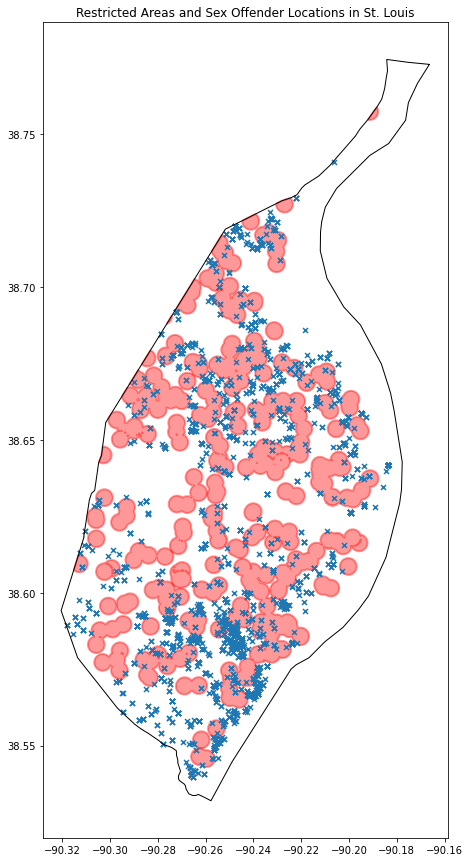

In [19]:
# set up plots
fig, ax = plt.subplots(figsize=(15, 15))

# apply our datasets to the plot
gdf_restricted_stl.plot(ax=ax, color='red', alpha=0.4, edgecolor='red', linewidth=2)
gdf_so_stl.plot(ax=ax, marker='x', markersize=25)
stlshape.plot(ax=ax, color='none', edgecolor='black')

plt.title("Restricted Areas and Sex Offender Locations in St. Louis")


### Find overlaps
In the plot above, we can see that some sex offenders are inside restricted zones. Let's break up the sex offender point data to identify compliance vs. potential noncompliance.

In [20]:
# Save the index values as a new column for simpler reference
gdf_so_stl['savedindex']= gdf_so_stl.index 

# Find the polygons that intersect. Keep savedindex as a series.
# intersecting = gdf_restricted_flat.sjoin(gdf_resparcels, how='inner')['savedindex'] # this requires gpd v0.10.0+
intersecting = gpd.sjoin(gdf_restricted_stl, gdf_so_stl, how='inner')['savedindex']

# turn the SO gdf into two new gdfs - one for SOs outside restricted areas and another for SOs within
gdf_so_compliant = gdf_so_stl[~gdf_so_stl.savedindex.isin(intersecting)].copy() # Filter away items where "savedindex is not in intersecting"
gdf_so_inrestricted = gdf_so_stl[gdf_so_stl.savedindex.isin(intersecting)].copy() 


Text(0.5, 1.0, 'Sex Offenders Residing INSIDE Restricted Areas')

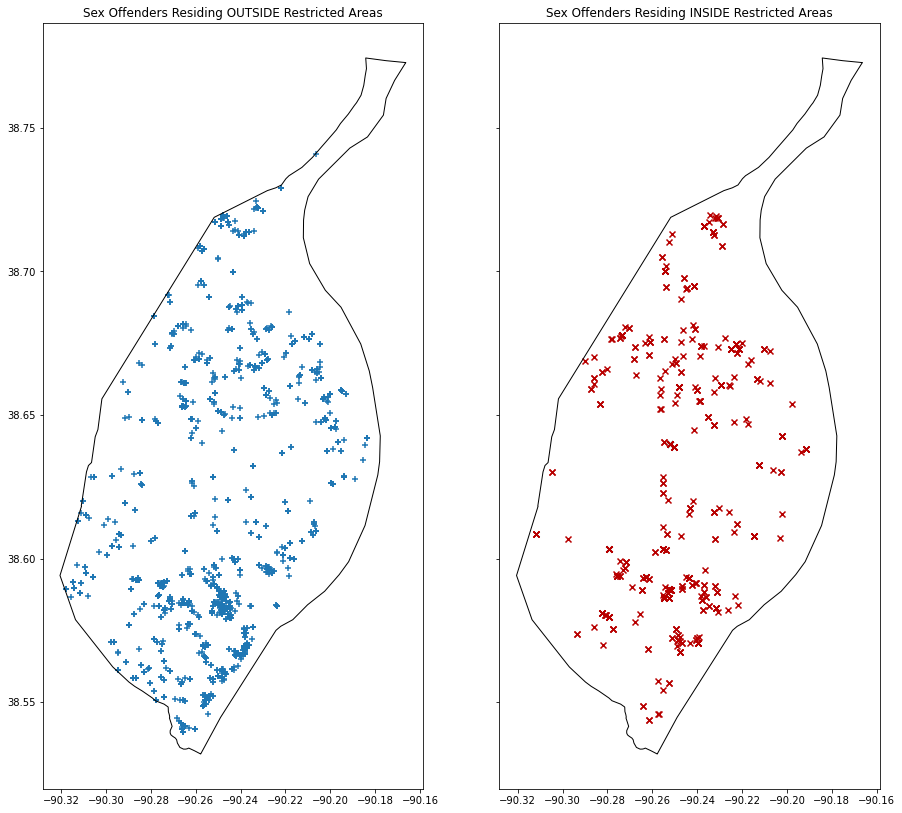

In [21]:
# show results side by side
fig, (ax1, ax2) = pyplot.subplots(ncols=2, sharex=True, sharey=True, figsize=(15,15))

# plot COMPLIANT offender locations
gdf_so_compliant.plot(ax=ax1, marker='+')
stlshape.plot(ax=ax1, color='none', edgecolor='black')
ax1.set_title('Sex Offenders Residing OUTSIDE Restricted Areas')

# plot POTENTIALLY NONCOMPLIANT offender locations
gdf_so_inrestricted.plot(ax=ax2, color='#b80000', marker='x')
stlshape.plot(ax=ax2, color='none', edgecolor='black')
ax2.set_title('Sex Offenders Residing INSIDE Restricted Areas')


Text(0.5, 1.0, 'Restricted Areas and Potentially Noncompliant\n Sex Offender Locations in St. Louis')

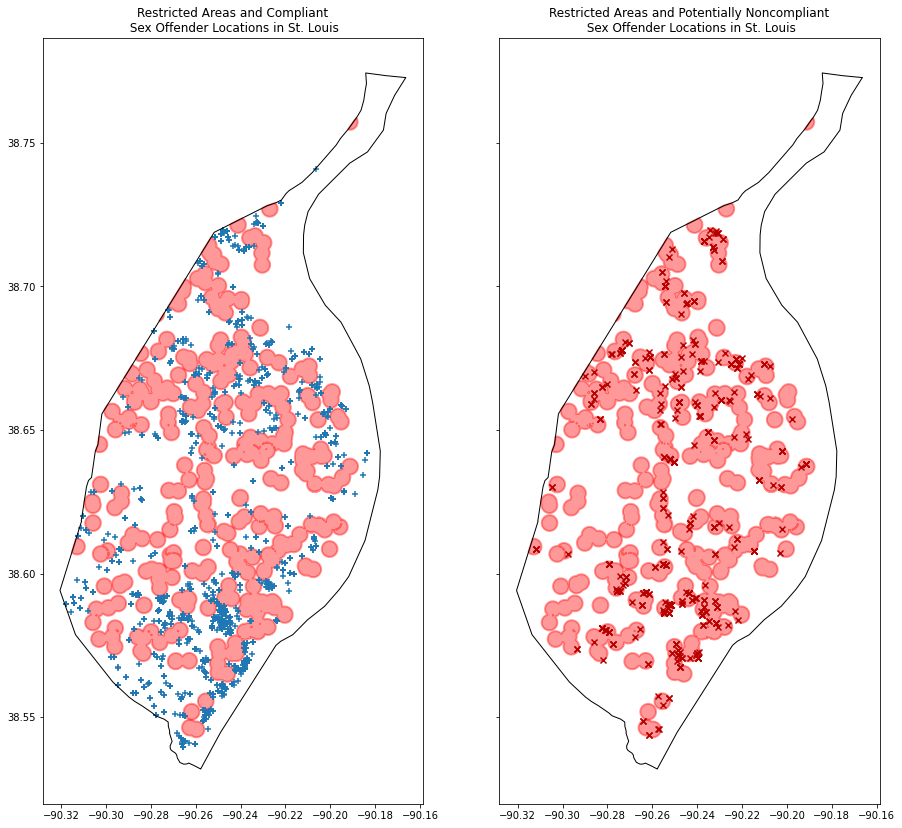

In [22]:
# put it all together in a side-by-side comparison
fig, (ax1, ax2) = pyplot.subplots(ncols=2, sharex=True, sharey=True, figsize=(15,15))

# plot COMPLIANT offender locations
gdf_restricted_stl.plot(ax=ax1, color='red', alpha=0.4, edgecolor='red', linewidth=2)
gdf_so_compliant.plot(ax=ax1, marker='+')
stlshape.plot(ax=ax1, color='none', edgecolor='black')
ax1.set_title("Restricted Areas and Compliant\n Sex Offender Locations in St. Louis")

# plot POTENTIALLY NONCOMPLIANT offender locations
gdf_restricted_stl.plot(ax=ax2, color='red', alpha=0.4, edgecolor='red', linewidth=2)
gdf_so_inrestricted.plot(ax=ax2, color='#b80000', marker='x')
stlshape.plot(ax=ax2, color='none', edgecolor='black')
ax2.set_title("Restricted Areas and Potentially Noncompliant\n Sex Offender Locations in St. Louis")



### Dig into dataframes to summarize counts, classifications, etc.

In [23]:
gdf_so_inrestricted.head()

LAYER  AREA_SQMI    SHAPE_area      SHAPE_len  \
4   --CITY_LIMIT_BOUND_2002--      62.11  1.845208e+09  218275.771282   
6   --CITY_LIMIT_BOUND_2002--      62.11  1.845208e+09  218275.771282   
14  --CITY_LIMIT_BOUND_2002--      62.11  1.845208e+09  218275.771282   
18  --CITY_LIMIT_BOUND_2002--      62.11  1.845208e+09  218275.771282   
34  --CITY_LIMIT_BOUND_2002--      62.11  1.845208e+09  218275.771282   

    randomid                 name           address         city  st    zip  \
4      40351      ADER, WILLIAM C   5214 FINKMAN ST  SAINT LOUIS  MO  63109   
6      50178  ALBUSSAIRI, YASIR A  4241 SCHILLER PL  SAINT LOUIS  MO  63116   
14      1541     ANDERSON, LESLIE     750 PONCE AVE  SAINT LOUIS  MO  63147   
18     44859   ANTONIO, DOMINGO S    3927 GREER AVE  SAINT LOUIS  MO  63107   
34     31650        BAIN, KEITH L  4809 MAFFITT AVE  SAINT LOUIS  MO  63113   

    ... date_of_birth offense_date conviction_date confinement_release_date  \
4   ...    1953-01-14   1984-08-01      1984-12-01               1987-03-01   
6   ...    1989-12-01   2010-01-22      2012-01-13                     None   
14  ...    1957-12-17   1975-04-08      1976-03-22               2021-12-27   
18  ...    1973-02-18   2009-01-25      2009-04-21               2014-07-25   
34  ...    1961-07-11   1980-08-29      1981-04-22                     None   

   probation/parole_release_date  offender_age_at_time_of_offense        lat  \
4                           None                               31  38.576171   
6                           None                               20  38.577846   
14                          None                               17  38.708928   
18                          None                               35  38.660333   
34                          None                               19  38.667925   

         long                    geometry savedindex  
4  -90.285774  POINT (-90.28577 38.57617)          4  
6  -90.267487  POINT (-90.26749 38.57785)          6  
14 -90.228816  POINT (-90.22882 38.70893)         14  
18 -90.226004  POINT (-90.22600 38.66033)         18  
34 -90.251404  POINT (-90.25140 38.66792)         34  

[5 rows x 29 columns]

In [24]:
# convert date strings to actual date format
gdf_so_compliant['offense_date'] = pd.to_datetime(gdf_so_compliant['offense_date'], format='%Y-%m-%d')
gdf_so_inrestricted['offense_date'] = pd.to_datetime(gdf_so_inrestricted['offense_date'], format='%Y-%m-%d')

In [25]:
# create a new column for just the YEAR of the offense
gdf_so_compliant['offense_year'] = gdf_so_compliant['offense_date'].dt.year
gdf_so_inrestricted['offense_year'] = gdf_so_inrestricted['offense_date'].dt.year

In [26]:
# make sure the results are as expected
print(gdf_so_compliant['offense_year'].dtypes)
print(gdf_so_inrestricted['offense_year'].dtypes)

float64
int64


In [27]:
# we have different data types in our new dataframes for the new 'offense_year' column! 
# let's see what's going on in the df with non-INT values
print(sorted(gdf_so_compliant.offense_year.unique()))

[1969.0, 1974.0, 1976.0, 1977.0, 1978.0, 1979.0, 1980.0, 1981.0, 1982.0, 1983.0, 1984.0, 1985.0, 1986.0, 1987.0, 1988.0, 1989.0, 1990.0, 1991.0, 1992.0, 1993.0, 1994.0, 1995.0, 1996.0, 1997.0, 1998.0, 1999.0, 2000.0, 2001.0, 2002.0, 2003.0, 2004.0, 2005.0, 2006.0, 2007.0, 2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0, 2014.0, 2015.0, 2016.0, 2017.0, 2018.0, 2019.0, nan, 2020.0]


In [28]:
# ...and check the "correct" df values for comparison
print(sorted(gdf_so_inrestricted.offense_year.unique()))

[1962, 1970, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]


#### There are a few interesting elements in play with these `NaN` entries.   

First and foremost, `NaN` occurs in one of our two sex offender dataframes. Though all of our `NaN` entries happen to coincide with offenders in the `compliant` class exclusively, it theoretically *could* happen with the `in_restricted` class as well. 

The second issue is that our version of pandas doesn't support `NaNs` in an `INT` column. That's the biggest thing we need to work around and the only reason we care to make some adjustment. Since we're dealing with years and the largest value is `2017`, we can substitute `9999` in place of `NaN`. This approach will make it easy to find and replace the value later (i.e during plotting). 

We will also go ahead and apply the fix to BOTH dataframes as a future-proofing measure.

In [29]:
# fix the 'offense_year' non-INT column
gdf_so_compliant['offense_year'] = gdf_so_compliant['offense_year'].fillna(9999).astype(int)
gdf_so_inrestricted['offense_year'] = gdf_so_inrestricted['offense_year'].fillna(9999).astype(int)

In [30]:
print(sorted(gdf_so_compliant.offense_year.unique()))

[1969, 1974, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 9999]


### Work up some summary information

In [31]:
# generate count of potentially noncompliant sex offenders by tier
ct_inrestricted_tier = gdf_so_inrestricted['tier'].value_counts().sort_index(ascending=True)

# generate count of ALL sex offenders by tier
ct_all_tier = gdf_so_stl['tier'].value_counts().sort_index(ascending=True)

# calculate percentage
per_tier = ct_inrestricted_tier / ct_all_tier

# combine all of the above into a single df to simplify output
df_ct_tier = pd.concat([ct_all_tier, ct_inrestricted_tier], axis=1)
df_ct_tier.columns = ['Count (All)','Count (Potentially Noncompliant)']

# add a row of totals
df_ct_tier.loc['Any'] = df_ct_tier.sum()

# calculate percentages
df_ct_tier['Percentage'] = df_ct_tier['Count (Potentially Noncompliant)'] / df_ct_tier['Count (All)'] 

# rename the index for better presentation
df_ct_tier = df_ct_tier.rename_axis('Offense Tier').reset_index()

# store the index of the last row
last_row = pd.IndexSlice[df_ct_tier.index[df_ct_tier.index == df_ct_tier.last_valid_index()], :]
# set up a bold font style
def df_style(val):
    return "font-weight: bold"

# apply style changes
df_ct_tier = df_ct_tier.style.format({'Percentage':'{:.1%}'.format}).set_table_styles(
                                    [dict(selector="th",props=[('max-width', '100px'),('text-align', 'center')])]
                                        ).applymap(df_style, subset=last_row)

df_ct_tier

In [32]:
# summary info sorted by tier - this is intended to be a sample of the output that could be provided to enforcement
df_display = gdf_so_inrestricted.sort_values('tier', ascending=False)
df_display = df_display.rename(columns = {'randomid':'offender_id'})
df_display['in_restr'] = True

# reduce the maximum width of a column for more concise display
pd.set_option('display.max_colwidth', 35)

# show nice summary output
df_display[['offender_id','in_restr','offense','tier','offense_year','address']].rename(
    columns = {'offender_id':'Offender ID','offense':'Offense','tier':'Tier','offense_year':'Offense Year','address':'Address'}).head(10)


Offender ID  in_restr                   Offense  Tier  Offense Year  \
1294        34858      True             FORCIBLE RAPE     3          1983   
1919        14616      True   SEXUAL ABUSE 1ST DEGREE     3          1991   
2156        13309      True      SEX ABUSE 3RD DEGREE     3          1988   
2155         3413      True      SEX ABUSE 3RD DEGREE     3          1991   
2151         4833      True  STATUTORY RAPE-2ND DEGRE     3          2015   
2132        21039      True  STATUTORY RAPE-2ND DEGRE     3          2015   
2131        26206      True            SEXUAL ASSAULT     3          1981   
2121         1367      True  STATUTORY SODOMY-1ST DEG     3          2001   
2114        35967      True  STATUTORY RAPE-2ND DEGRE     3          1998   
2006        43418      True        INDECENT LIBERTIES     3          1980   

                         Address  
1294                5106 PALM ST  
1919  3938 DUNNICA AVE APT 2ND A  
2156        2228 OLIVE ST RM 223  
2155        2228 OLIVE ST RM 223  
2151      4045 GRAVOIS AVE APT A  
2132     3927 CHIPPEWA ST APT 2E  
2131         3104 EADS AVE APT C  
2121      4949 OLEATHA AVE APT B  
2114    4050 DELMAR BLVD APT 105  
2006       8402 CHURCH RD FL 2ND

In [33]:
# restore the max_colwidth to its original value
pd.set_option('display.max_colwidth', 50)


In [34]:
# display a breakdown of the most frequently-occurring offenses within the potentially noncompliant class
num_to_show = 15
gdf_so_inrestricted[['offense','tier']].rename(columns = {'offense':'Offense','tier':'Tier'}
      ).value_counts().reset_index(name='Count').head(num_to_show).style.set_table_styles(
            [dict(selector="th",props=[('text-align', 'center')])]).set_properties(**{'text-align': 'right'})


In [35]:
# take a look at how potential noncompliance correlates to offense year 
gdf_so_inrestricted[['offense_year']].value_counts().sort_index(ascending=True)

offense_year
1962             1
1970             1
1972             2
1973             2
1974             3
1975             4
1976             4
1977             4
1978             5
1979             4
1980             9
1981             7
1982            20
1983            12
1984             3
1985            11
1986             7
1987            12
1988            10
1989            32
1990             8
1991            21
1992            24
1993            17
1994            43
1995            16
1996            12
1997            33
1998            16
1999            11
2000            19
2001            28
2002            18
2003            12
2004             3
2005             8
2006            16
2007            18
2008            14
2009            14
2010             2
2011             2
2012             3
2013            13
2014            10
2015             3
2016             1
2017             5
dtype: int64

### Plot both offender classes on folium with labels

Let's pull all the above work together into a single, highly-interactive display via folium.

First, we'll grab the shapefile of the St. Louis City mask. See [this notebook](test/Test_Folium_Mask.ipynb) for a walkthrough of how that artifact was developed.

In [36]:
# read in the shapefile 
stlmask = gpd.read_file('data/stl_city_mask/')
# convert to the same CRS as the other datasets
stlmask = stlmask.to_crs(gdf_so.crs)


Now we can set up a folium map that breaks out  

- Sex offenders by class (compliant vs. potentially noncompliant)  
- Sex offenders by tier (different color shades for each tier)  
- Summary info for each sex offender (ID, year of offense, offense, tier)  
- Restricted zones by source of contribution (public schools, private schools, childcare facilities)

In [37]:
# set up folium map with FeatureGroup layers
map_results = folium.Map([38.64, -90.25], tiles=None, zoom_start=12)
tile_layer = folium.TileLayer(tiles='openstreetmap', control=False)
tile_layer.add_to(map_results)

# set up feature group and subgroups for COMPLIANT offender class
fg_so_compliant = folium.FeatureGroup(name='Compliant Sex Offenders').add_to(map_results)

# we can use one of these symbols to better identify subgroups on the legend: ⤷ or ↳
cg1 = folium.plugins.FeatureGroupSubGroup(fg_so_compliant, '⤷ Tier 1 (Compliant)')
cg2 = folium.plugins.FeatureGroupSubGroup(fg_so_compliant, '⤷ Tier 2 (Compliant)')
cg3 = folium.plugins.FeatureGroupSubGroup(fg_so_compliant, '⤷ Tier 3 (Compliant)')
map_results.add_child(cg1)
map_results.add_child(cg2)
map_results.add_child(cg3)

# set up feature group and subgroups for IN RESTRICTED offender class
fg_so_inrestricted = folium.FeatureGroup(name='Potentially Noncompliant Sex Offenders').add_to(map_results)

rg1 = folium.plugins.FeatureGroupSubGroup(fg_so_inrestricted, '⤷ Tier 1 (Potentially Noncompliant)')
rg2 = folium.plugins.FeatureGroupSubGroup(fg_so_inrestricted, '⤷ Tier 2 (Potentially Noncompliant)')
rg3 = folium.plugins.FeatureGroupSubGroup(fg_so_inrestricted, '⤷ Tier 3 (Potentially Noncompliant)')
map_results.add_child(rg1)
map_results.add_child(rg2)
map_results.add_child(rg3)

# create dictionaries so subgroups are easily accessible within loops
com_fgs = {1: cg1, 2: cg2, 3: cg3}
res_fgs = {1: rg1, 2: rg2, 3: rg3}

# ...and create dictionaries of colors to go with the subgroups
com_cols = {1:'lightgreen', 2:'green', 3:'darkgreen'}
res_cols = {1:'lightred', 2:'red', 3:'darkred'}

# set up feature group and subgroups for RESTRICTED AREAS
fg_res_areas = folium.FeatureGroup(name='Restricted Area').add_to(map_results)
resg1 = folium.plugins.FeatureGroupSubGroup(fg_res_areas, '⤷ Public Schools', show=False)
resg2 = folium.plugins.FeatureGroupSubGroup(fg_res_areas, '⤷ Private Schools', show=False)
resg3 = folium.plugins.FeatureGroupSubGroup(fg_res_areas, '⤷ Childcare Facilities', show=False)
map_results.add_child(resg1)
map_results.add_child(resg2)
map_results.add_child(resg3)

# apply the overall restricted areas to the feature group
folium.GeoJson(gdf_restricted_stl, name='Restricted Area', style_function=lambda feature: {
        'fillColor': '#db3e00', 'color': '#db3e00'}).add_to(fg_res_areas)

# apply the PUBLIC SCHOOLS restricted areas to the map within the applicable subgroub 
folium.GeoJson(gdf_restricted_pub, style_function=lambda feature: {
        'fillColor': '#2E89C5', 'color': '#2E89C5'}).add_to(resg1)

# apply the PRIVATE SCHOOLS restricted areas to the map within the applicable subgroub 
folium.GeoJson(gdf_restricted_pvt, style_function=lambda feature: {
        'fillColor': '#A854D5', 'color': '#A854D5'}).add_to(resg2)

# apply the CHILDCARE FACILITY restricted areas to the map within the applicable subgroub 
folium.GeoJson(gdf_restricted_child, style_function=lambda feature: {
        'fillColor': '#DE8F1F', 'color': '#DE8F1F'}).add_to(resg3)


# apply the STL City boundary mask to the map
folium.GeoJson(stlmask, name='Mask Around St. Louis', control=False, style_function=lambda feature: {
        'fillColor': '#000000', 'color': '#000000'}).add_to(map_results)


####### Plot points for COMPLIANT offenders
# add a marker for offenders outside a restricted area
# label each offender with their offense
# do this by tier - loop through tiers one at a time and associate with a feature subgroup
for tier in range(1,4):
    gdf_tier = gdf_so_compliant.loc[gdf_so_compliant['tier'] == tier]
    for i in range(0,len(gdf_tier)):
        folium.Marker(
          location=[gdf_tier.iloc[i]['lat'], gdf_tier.iloc[i]['long']],
           # create a popup with summary info
            popup=folium.Popup("<b>ID:</b> "+gdf_tier.iloc[i]['randomid'].astype(str)+"<br>"
                              # for offense_year, remember that we had "9999" fill in for "NaN"/no data
                              "<b>Year of Offense:</b> "+gdf_tier.iloc[i]['offense_year'].astype(str).replace('9999','--not reported--')+"<br>"
                              "<b>Offense:</b> "+gdf_tier.iloc[i]['offense']+"<br>"
                              "<b>Tier:</b> "+gdf_tier.iloc[i]['tier'].astype(str),
                              max_width=750),
           # icon colors are based on the dictionary map we created earlier 
            icon=folium.Icon(color=com_cols[tier], icon='glyphicon-ok-sign', prefix='glyphicon')
       ).add_to(com_fgs[tier]) # add this point to the appropriate feature subgroup



####### Plot points for IN RESTRICTED offenders
# this is a repeat of what we did with COMPLIANT offenders, just changing the input df
# add a marker for offenders in a restricted area
# label each offender with their offense
# do this by tier - loop through tiers one at a time and associate with a feature subgroup
for tier in range(1,4):
    gdf_tier = gdf_so_inrestricted.loc[gdf_so_inrestricted['tier'] == tier]
    for i in range(0,len(gdf_tier)):
        folium.Marker(
          location=[gdf_tier.iloc[i]['lat'], gdf_tier.iloc[i]['long']],
           popup=folium.Popup("<b>ID:</b> "+gdf_tier.iloc[i]['randomid'].astype(str)+"<br>"
                              "<b>Year of Offense:</b> "+gdf_tier.iloc[i]['offense_year'].astype(str).replace('9999',"--not reported--")+"<br>"
                              "<b>Offense:</b> "+gdf_tier.iloc[i]['offense']+"<br>"
                              "<b>Tier:</b> "+gdf_tier.iloc[i]['tier'].astype(str),
                              max_width=750),
           icon=folium.Icon(color=res_cols[tier], icon='glyphicon-remove-sign', prefix='glyphicon')
       ).add_to(res_fgs[tier])


# Add layer control to the map
folium.LayerControl(collapsed=False, position='topright').add_to(map_results)

# display map
map_results


### Output results to HTML file

In [42]:
# set up a title for the page - this needs to use HTML tags appropriately
title_html = '<title>St. Louis Sex Offender Locations and Status</title>'

# apply the title to the map data
map_results.get_root().html.add_child(folium.Element(title_html))

# save to a file 
map_results.save("stl_so.html")


# Summary

We have answered the final question for this project. We not only demonstrated that there are a significant number of offenders who may be in violation of the special consideration restrictions, we also provided a way for our audience to explore offender locations relative to the restricted areas within St. Louis via a standalone (HTML) page.



# Conclusion

This wraps up our project on an examination of the impacts of sex offender residence restrictions in St. Louis, MO. We conducted our data ingest, carpentry, and database loading; we fused together the material components in a manner that is conducive to answering our three actionable questions; and we completed processing, analysis, and generation of audience-relevant presentation/visualization elements needed to answer those questions.

Thank you for stepping through these notebooks and this topic with me!